In [2]:
# ต้องมาก่อนการใช้ TensorFlow ทุกอย่าง!
import os
import random
import numpy as np
import tensorflow as tf

# ===== ตั้งค่าความเสถียรและ reproducibility =====
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# ปิด multi-threading ของ TensorFlow
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

from typing import Tuple, List
import pandas as pd
from scipy.stats import ks_2samp, mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Preprocess data
df = pd.read_csv("nvidia_10yr_data.csv", parse_dates=["Date"])
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")
df = df.sort_values("Date")

# Feature engineering
df['Return'] = df['Close'].pct_change()
df['Volatility'] = df['Close'].rolling(10).std()
df['Price_Diff'] = df['High'] - df['Low']
df['Volume_Log'] = np.log1p(df['Volume'])

# Drop NaN หลัง rolling
df.dropna(inplace=True)

X = df[['Return', 'Volatility', 'Price_Diff', 'Volume_Log']]
y = df['Close']

class SequenceGenerator:
    """
    สร้าง sequence data สำหรับ RNN-based models
    """
    def __init__(self, sequence_length: int = 30):
        self.sequence_length = sequence_length
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()
        
    def create_sequences(self, X: pd.DataFrame, y: pd.Series, fit_scalers: bool = True):
        """
        สร้าง sequence data สำหรับ RNN-based models
        """
        # Scale features
        if fit_scalers:
            X_scaled = self.scaler_X.fit_transform(X)
            y_scaled = self.scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
        else:
            X_scaled = self.scaler_X.transform(X)
            y_scaled = self.scaler_y.transform(y.values.reshape(-1, 1)).flatten()
        
        # Create sequences
        X_seq, y_seq = [], []
        for i in range(self.sequence_length, len(X_scaled)):
            X_seq.append(X_scaled[i-self.sequence_length:i])
            y_seq.append(y_scaled[i])
        
        return np.array(X_seq), np.array(y_seq)
    
    def inverse_transform_y(self, y_scaled):
        """
        แปลงค่า y กลับเป็นสเกลเดิม
        """
        return self.scaler_y.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

class RNNRegressor:
    """
    Universal RNN Regressor ที่รองรับ RNN, LSTM, และ GRU
    """
    def __init__(self, model_type: str = 'LSTM', sequence_length: int = 30, 
                 units: int = 50, dropout_rate: float = 0.2, 
                 learning_rate: float = 0.001, epochs: int = 100, 
                 batch_size: int = 32, verbose: int = 0):
        
        self.model_type = model_type.upper()
        self.sequence_length = sequence_length
        self.units = units
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None
        self.seq_generator = SequenceGenerator(sequence_length)
        
        # ตรวจสอบว่า model_type ถูกต้อง
        if self.model_type not in ['RNN', 'LSTM', 'GRU']:
            raise ValueError("model_type must be 'RNN', 'LSTM', or 'GRU'")
        
    def _get_layer_type(self):
        """
        เลือก layer type ตาม model_type
        """
        if self.model_type == 'RNN':
            return SimpleRNN
        elif self.model_type == 'LSTM':
            return LSTM
        elif self.model_type == 'GRU':
            return GRU
        
    def _build_model(self, input_shape):
        """
        สร้างโมเดล RNN ตาม model_type
        """
        LayerType = self._get_layer_type()
        
        model = Sequential([
            LayerType(self.units, return_sequences=True, input_shape=input_shape),
            Dropout(self.dropout_rate),
            LayerType(self.units // 2, return_sequences=False),
            Dropout(self.dropout_rate),
            Dense(25, activation='relu'),
            Dense(1)
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=self.learning_rate),
            loss='mse',
            metrics=['mae']
        )
        
        return model
    
    def fit(self, X: pd.DataFrame, y: pd.Series):
        """
        Train RNN model
        """
        # Create sequences
        X_seq, y_seq = self.seq_generator.create_sequences(X, y, fit_scalers=True)
        
        if len(X_seq) == 0:
            raise ValueError("Not enough data to create sequences")
        
        # Build model
        self.model = self._build_model((X_seq.shape[1], X_seq.shape[2]))
        
        # Early stopping
        early_stopping = EarlyStopping(
            monitor='loss',
            patience=10,
            restore_best_weights=True
        )
        
        # Train model
        self.model.fit(
            X_seq, y_seq,
            epochs=self.epochs,
            batch_size=self.batch_size,
            callbacks=[early_stopping],
            verbose=self.verbose
        )
        
        return self
    
    def predict(self, X: pd.DataFrame):
        """
        Make predictions
        """
        if self.model is None:
            raise ValueError("Model not fitted yet")
        
        # Create sequences (don't fit scalers)
        X_seq, _ = self.seq_generator.create_sequences(
            X, pd.Series([0] * len(X)), fit_scalers=False
        )
        
        if len(X_seq) == 0:
            # Return predictions for available data points
            return np.array([])
        
        # Predict
        y_pred_scaled = self.model.predict(X_seq, verbose=0)
        
        # Inverse transform
        y_pred = self.seq_generator.inverse_transform_y(y_pred_scaled)
        
        return y_pred

class LinearRegressionModel:
    """
    Linear Regression model with standardization
    """
    def __init__(self, fit_intercept: bool = True):
        self.fit_intercept = fit_intercept
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()
        self.model = LinearRegression(fit_intercept=fit_intercept)
        self.is_fitted = False
        
    def fit(self, X: pd.DataFrame, y: pd.Series):
        """
        Train Linear Regression model
        """
        # Scale features
        X_scaled = self.scaler_X.fit_transform(X)
        y_scaled = self.scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
        
        # Train model
        self.model.fit(X_scaled, y_scaled)
        self.is_fitted = True
        
        return self
    
    def predict(self, X: pd.DataFrame):
        """
        Make predictions
        """
        if not self.is_fitted:
            raise ValueError("Model not fitted yet")
        
        # Scale features
        X_scaled = self.scaler_X.transform(X)
        
        # Predict
        y_pred_scaled = self.model.predict(X_scaled)
        
        # Inverse transform
        y_pred = self.scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
        
        return y_pred

class DriftPointDetector:
    """
    ตรวจจับจุดเกิด concept drift ในข้อมูล time series ด้วยการใช้
    หลายวิธีทดสอบและป้องกันการจับ pattern ที่ผิดพลาด
    """
    def __init__(self, window_size: int = 120, threshold: float = 0.001, 
                 step_size: int = 30, min_effect_size: float = 0.3,
                 stability_window: int = 60, confirmation_tests: int = 2): 
        self.window_size = window_size # ขนาดหน้าต่างสำหรับการตรวจจับ drift
        self.threshold = threshold # ค่าความสำคัญสำหรับการทดสอบ
        self.step_size = step_size # ขนาด step สำหรับการเลื่อนหน้าต่าง
        self.min_effect_size = min_effect_size # ขนาดผลกระทบขั้นต่ำที่ต้องการ
        self.stability_window = stability_window # หน้าต่างเสถียรภาพก่อนการตรวจจับ drift
        self.confirmation_tests = confirmation_tests # จำนวนการทดสอบยืนยันที่ต้องผ่านก่อนที่จะถือว่าเป็น drift
        self.drift_points_: List[int] = [] # จุดที่ตรวจจับได้

    def _calculate_effect_size(self, window1: pd.Series, window2: pd.Series) -> float:
        """คำนวณขนาดผลกระทบ (Cohen's d)"""
        mean1, mean2 = window1.mean(), window2.mean()
        std1, std2 = window1.std(), window2.std()
        
        pooled_std = np.sqrt(((len(window1) - 1) * std1**2 + (len(window2) - 1) * std2**2) / 
                           (len(window1) + len(window2) - 2))
        
        if pooled_std == 0:
            return 0
        
        return abs(mean1 - mean2) / pooled_std

    def _test_multiple_statistics(self, window1: pd.DataFrame, window2: pd.DataFrame) -> Tuple[int, float]:
        """ทดสอบหลายวิธีเพื่อยืนยัน drift"""
        passed_tests = 0 # จำนวนการทดสอบที่ผ่าน
        min_p_value = 1.0 # ค่าพื้นฐานสำหรับ p-value
        
        for col in window1.columns:
            col_tests = 0
            col_p_values = []
            
            # Test 1: Kolmogorov-Smirnov test
            try:
                stat, p_value = ks_2samp(window1[col], window2[col])
                col_p_values.append(p_value)
                if p_value < self.threshold:
                    col_tests += 1
            except:
                pass
            
            # Test 2: Mann-Whitney U test
            try:
                stat, p_value = mannwhitneyu(window1[col], window2[col], alternative='two-sided')
                col_p_values.append(p_value)
                if p_value < self.threshold:
                    col_tests += 1
            except:
                pass
            
            # Test 3: Effect size check
            effect_size = self._calculate_effect_size(window1[col], window2[col]) # ขนาดผลกระทบ
            if effect_size > self.min_effect_size: # ขนาดผลกระทบที่ต้องการ
                col_tests += 1 # เพิ่มการทดสอบขนาดผลกระทบ
            
            if col_p_values:
                min_p_value = min(min_p_value, min(col_p_values))
            
            if col_tests >= self.confirmation_tests: # ต้องผ่านการทดสอบยืนยันขั้นต่ำ
                passed_tests += 1
        
        return passed_tests, min_p_value # ค่าพื้นฐานสำหรับ p-value

    def _check_stability_before_drift(self, X: pd.DataFrame, position: int) -> bool:
        """ตรวจสอบว่าช่วงก่อนหน้ามีเสถียรภาพหรือไม่"""
        if position < self.stability_window + self.window_size:
            return True
        
        stable_start = position - self.stability_window - self.window_size
        stable_end = position - self.window_size
        stable_window = X.iloc[stable_start:stable_end]
        
        mid_point = len(stable_window) // 2
        stable_part1 = stable_window.iloc[:mid_point]
        stable_part2 = stable_window.iloc[mid_point:]
        
        for col in X.columns:
            if len(stable_part1) > 0 and len(stable_part2) > 0:
                try:
                    stat, p_value = ks_2samp(stable_part1[col], stable_part2[col])
                    if p_value < self.threshold * 10:
                        return False
                except:
                    pass
        
        return True

    def _remove_pattern_drifts(self, drift_candidates: List[Tuple[int, float]]) -> List[int]:
        """กรองจุด drift ที่อาจเป็น pattern"""
        if len(drift_candidates) < 3: # ถ้ามีน้อยกว่า 3 จุด ไม่ต้องกรอง
            return [pos for pos, _ in drift_candidates]
        
        drift_candidates.sort(key=lambda x: x[0]) # เรียงตามตำแหน่ง
        
        intervals = []
        for i in range(1, len(drift_candidates)):
            interval = drift_candidates[i][0] - drift_candidates[i-1][0]
            intervals.append(interval)
        
        filtered_drifts = []
        if len(intervals) > 1:
            interval_std = np.std(intervals)
            interval_mean = np.mean(intervals)
            
            if interval_std / interval_mean < 0.3: 
                drift_candidates.sort(key=lambda x: x[1])
                keep_count = max(1, len(drift_candidates) // 3)
                filtered_drifts = [pos for pos, _ in drift_candidates[:keep_count]]
            else:
                filtered_drifts = [pos for pos, _ in drift_candidates]
        else:
            filtered_drifts = [pos for pos, _ in drift_candidates]
        
        final_drifts = []
        min_distance = self.window_size * 2
        
        for pos in sorted(filtered_drifts):
            if not final_drifts or pos - final_drifts[-1] >= min_distance:
                final_drifts.append(pos)
        
        return final_drifts

    def detect(self, X: pd.DataFrame) -> List[int]:
        self.drift_points_ = []
        n = len(X)
        drift_candidates = []
        
        for i in range(self.window_size, n - self.window_size, self.step_size):
            if not self._check_stability_before_drift(X, i):
                continue
            
            window1 = X.iloc[i - self.window_size:i]
            window2 = X.iloc[i:i + self.window_size]
            
            passed_tests, min_p_value = self._test_multiple_statistics(window1, window2)
            
            if passed_tests >= 1:
                drift_candidates.append((i, min_p_value))
        
        self.drift_points_ = self._remove_pattern_drifts(drift_candidates)
        
        return self.drift_points_

class AdaptiveFoldGenerator:
    """
    สร้าง train/test folds โดยแบ่งตาม drift points ที่ตรวจจับได้
    """
    def __init__(self, min_fold_size: int = 120, test_ratio: float = 0.2):
        self.min_fold_size = min_fold_size
        self.test_ratio = test_ratio

    def split(self, X: pd.DataFrame, drift_points: List[int]) -> List[Tuple[np.ndarray, np.ndarray]]:
        folds = []
        points = [0] + drift_points + [len(X)]
        
        for i in range(len(points) - 1):
            start, end = points[i], points[i + 1]
            fold_length = end - start

            if fold_length < self.min_fold_size:
                continue

            split = int(start + (1 - self.test_ratio) * fold_length)
            train_idx = np.arange(start, split)
            test_idx = np.arange(split, end)

            # เพิ่มขนาดขั้นต่ำสำหรับ RNN models
            if len(train_idx) > 100 and len(test_idx) > 50: # ขนาดขั้นต่ำสำหรับ train/test
                folds.append((train_idx, test_idx))
        
        return folds

class DriftAdaptiveTimeSeriesCV:
    """
    ทำ cross-validation โดยใช้ fold ที่แบ่งตาม drift points สำหรับ RNN models และ Linear Regression
    """
    def __init__(self, model_type: str = 'LSTM', model_params: dict = None):
        self.model_type = model_type.upper()
        self.model_params = model_params or {
            'sequence_length': 30,
            'units': 50,
            'dropout_rate': 0.3,
            'learning_rate': 0.001,
            'epochs': 50,
            'batch_size': 32,
            'verbose': 0
        }

    def run(self, X: pd.DataFrame, y: pd.Series, drift_points: List[int]) -> Tuple[List[float], List[float]]:
        fold_gen = AdaptiveFoldGenerator()
        metrics_rmse, metrics_mae = [], []

        folds = fold_gen.split(X, drift_points)
        if not folds:
            print("Warning: No valid folds generated by AdaptiveFoldGenerator!")
            return [], []

        for i, (train_idx, test_idx) in enumerate(folds):
            print(f"\n[Adaptive Fold {i+1}] Training {self.model_type}...")
            
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # สร้างโมเดล ใหม่สำหรับแต่ละ fold
            if self.model_type in ['RNN', 'LSTM', 'GRU']:
                model = RNNRegressor(model_type=self.model_type, **self.model_params)
            elif self.model_type == 'LINEAR':
                model = LinearRegressionModel(**self.model_params)
            else:
                raise ValueError(f"Unknown model type: {self.model_type}")
            
            try:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                
                # Align predictions with actual values (สำหรับ RNN models เนื่องจาก sequence length)
                if self.model_type in ['RNN', 'LSTM', 'GRU']:
                    if len(y_pred) > 0:
                        y_test_aligned = y_test.iloc[model.seq_generator.sequence_length:]
                        y_test_aligned = y_test_aligned.iloc[:len(y_pred)]
                        
                        rmse = np.sqrt(mean_squared_error(y_test_aligned, y_pred))
                        mae = mean_absolute_error(y_test_aligned, y_pred)
                    else:
                        print(f"[Adaptive Fold {i+1}] No predictions generated (insufficient data)")
                        continue
                else:  # สำหรับ Linear Regression
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    mae = mean_absolute_error(y_test, y_pred)
                
                print(f"[Adaptive Fold {i+1}] RMSE={rmse:.3f}, MAE={mae:.3f}")
                
                metrics_rmse.append(rmse)
                metrics_mae.append(mae)
                    
            except Exception as e:
                print(f"[Adaptive Fold {i+1}] Error: {e}")
                continue

        return metrics_rmse, metrics_mae

class BaselineTimeSeriesCV:
    """
    ทำ cross-validation แบบ TimeSeriesSplit ปกติ สำหรับ RNN models และ Linear Regression
    """
    def __init__(self, model_type: str = 'LSTM', model_params: dict = None, n_splits: int = 5):
        self.model_type = model_type.upper()
        self.model_params = model_params or {
            'sequence_length': 30,
            'units': 50,
            'dropout_rate': 0.3,
            'learning_rate': 0.001,
            'epochs': 50,
            'batch_size': 32,
            'verbose': 0
        }
        self.n_splits = n_splits

    def run(self, X: pd.DataFrame, y: pd.Series) -> Tuple[List[float], List[float]]:
        tscv = TimeSeriesSplit(n_splits=self.n_splits)
        metrics_rmse, metrics_mae = [], []

        for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
            print(f"\n[Baseline Fold {i+1}] Training {self.model_type}...")
            
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # สร้างโมเดล ใหม่สำหรับแต่ละ fold
            if self.model_type in ['RNN', 'LSTM', 'GRU']:
                model = RNNRegressor(model_type=self.model_type, **self.model_params)
            elif self.model_type == 'LINEAR':
                model = LinearRegressionModel(**self.model_params)
            else:
                raise ValueError(f"Unknown model type: {self.model_type}")
            
            try:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                
                # Align predictions with actual values (สำหรับ RNN models)
                if self.model_type in ['RNN', 'LSTM', 'GRU']:
                    if len(y_pred) > 0:
                        y_test_aligned = y_test.iloc[model.seq_generator.sequence_length:]
                        y_test_aligned = y_test_aligned.iloc[:len(y_pred)]
                        
                        rmse = np.sqrt(mean_squared_error(y_test_aligned, y_pred))
                        mae = mean_absolute_error(y_test_aligned, y_pred)
                    else:
                        print(f"[Baseline Fold {i+1}] No predictions generated (insufficient data)")
                        continue
                else:  # สำหรับ Linear Regression
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    mae = mean_absolute_error(y_test, y_pred)
                
                print(f"[Baseline Fold {i+1}] RMSE={rmse:.3f}, MAE={mae:.3f}")
                
                metrics_rmse.append(rmse)
                metrics_mae.append(mae)
                    
            except Exception as e:
                print(f"[Baseline Fold {i+1}] Error: {e}")
                continue

        return metrics_rmse, metrics_mae

class ModelComparison:
    """
    เปรียบเทียบประสิทธิภาพของ RNN, LSTM, GRU และ Linear Regression
    """
    def __init__(self, rnn_params: dict = None, linear_params: dict = None):
        self.rnn_params = rnn_params or {
            'sequence_length': 30,
            'units': 50,
            'dropout_rate': 0.3,
            'learning_rate': 0.001,
            'epochs': 50,
            'batch_size': 32,
            'verbose': 0
        }
        self.linear_params = linear_params or {'fit_intercept': True}
        self.models = ['RNN', 'LSTM', 'GRU', 'LINEAR']
        
    def compare_models(self, X: pd.DataFrame, y: pd.Series, drift_points: List[int]):
        """
        เปรียบเทียบโมเดลทั้งหมดด้วย adaptive CV
        """
        results = {}
        
        for model_type in self.models:
            print(f"\n{'='*50}")
            print(f"Testing {model_type} Model")
            print(f"{'='*50}")
            
            # เลือกพารามิเตอร์ที่เหมาะสมตามประเภทโมเดล
            if model_type == 'LINEAR':
                params = self.linear_params
            else:
                params = self.rnn_params
            
            # Adaptive CV
            drift_cv = DriftAdaptiveTimeSeriesCV(model_type, params)
            drift_rmse, drift_mae = drift_cv.run(X, y, drift_points)
            
            # Baseline CV
            baseline_cv = BaselineTimeSeriesCV(model_type, params, n_splits=5)
            base_rmse, base_mae = baseline_cv.run(X, y)
            
            results[model_type] = {
                'adaptive_rmse': drift_rmse,
                'adaptive_mae': drift_mae,
                'baseline_rmse': base_rmse,
                'baseline_mae': base_mae
            }
        
        return results
    
    def print_summary(self, results: dict):
        """
        พิมพ์สรุปผลลัพธ์การเปรียบเทียบ
        """
        print("\n" + "="*80)
        print("MODEL COMPARISON SUMMARY")
        print("="*80)
        
        for model_type in self.models:
            if model_type in results:
                print(f"\n{model_type} Results:")
                print("-" * 30)
                
                # Adaptive results
                if results[model_type]['adaptive_rmse'] and results[model_type]['adaptive_mae']:
                    avg_rmse = np.mean(results[model_type]['adaptive_rmse'])
                    avg_mae = np.mean(results[model_type]['adaptive_mae'])
                    print(f"Adaptive CV - Avg RMSE: {avg_rmse:.3f}, Avg MAE: {avg_mae:.3f}")
                else:
                    print("Adaptive CV - No valid results")
                
                # Baseline results
                if results[model_type]['baseline_rmse'] and results[model_type]['baseline_mae']:
                    avg_rmse = np.mean(results[model_type]['baseline_rmse'])
                    avg_mae = np.mean(results[model_type]['baseline_mae'])
                    print(f"Baseline CV - Avg RMSE: {avg_rmse:.3f}, Avg MAE: {avg_mae:.3f}")
                else:
                    print("Baseline CV - No valid results")
        
        # หาโมเดลที่ดีที่สุด
        best_model = self._find_best_model(results)
        if best_model:
            print(f"\nBest Model: {best_model}")
    
    def _find_best_model(self, results: dict):
        """
        หาโมเดลที่ดีที่สุดจากผลลัพธ์
        """
        best_model = None
        best_score = float('inf')
        
        for model_type in self.models:
            if model_type in results:
                # ใช้ adaptive RMSE เป็นเกณฑ์
                if results[model_type]['adaptive_rmse']:
                    avg_rmse = np.mean(results[model_type]['adaptive_rmse'])
                    if avg_rmse < best_score:
                        best_score = avg_rmse
                        best_model = model_type
                # ถ้าไม่มี adaptive results ใช้ baseline
                elif results[model_type]['baseline_rmse']:
                    avg_rmse = np.mean(results[model_type]['baseline_rmse'])
                    if avg_rmse < best_score:
                        best_score = avg_rmse
                        best_model = model_type
        
        return best_model

# ตัวอย่างการใช้งานที่ถูกต้อง
if __name__ == "__main__":
    # 1) Detect drift points
    detector = DriftPointDetector(
        window_size=120, # ขนาดหน้าต่างสำหรับการตรวจจับ drift
        threshold=0.001,  
        step_size=30, # ขนาด step สำหรับการเลื่อนหน้าต่าง
        min_effect_size=0.3, # ขนาดผลกระทบขั้นต่ำที่ต้องการ
        stability_window=60,    # หน้าต่างเสถียรภาพก่อนการตรวจจับ drift
        confirmation_tests=2 # จำนวนการทดสอบยืนยันที่ต้องผ่านก่อนที่จะถือว่าเป็น drift
    )
    drift_points = detector.detect(X)
    
    # 2) เปรียบเทียบโมเดลทั้งหมด
    rnn_params = {
        'sequence_length': 30,
        'units': 50, # จำนวนหน่วยใน LSTM/GRU
        'dropout_rate': 0.3, # อัตราการ dropout
        'learning_rate': 0.001, # อัตราการเรียนรู้
        'epochs': 30, # จำนวน epoch สำหรับการฝึก
        'batch_size': 32, # ขนาด batch สำหรับการฝึก
        'verbose': 0 # ระดับการแสดงผล (0 = ไม่มีการแสดงผล)
    }
    
    linear_params = {'fit_intercept': True}
    
    comparator = ModelComparison(rnn_params=rnn_params, linear_params=linear_params)
    results = comparator.compare_models(X, y, drift_points)
    comparator.print_summary(results)

    # แปลง drift point index เป็นวันที่แบบ วัน/เดือน/ปี
    drift_dates_formatted = df.iloc[drift_points]['Date'].dt.strftime('%d/%m/%Y').tolist()
    print("\nDrift Dates:")
    print(drift_dates_formatted)



Testing RNN Model

[Adaptive Fold 1] Training RNN...
[Adaptive Fold 1] RMSE=0.589, MAE=0.581

[Adaptive Fold 2] Training RNN...
[Adaptive Fold 2] RMSE=1.468, MAE=1.415

[Adaptive Fold 3] Training RNN...
[Adaptive Fold 3] RMSE=7.562, MAE=7.500

[Adaptive Fold 4] Training RNN...
[Adaptive Fold 4] RMSE=15.405, MAE=14.389

[Baseline Fold 1] Training RNN...
[Baseline Fold 1] RMSE=2.939, MAE=2.616

[Baseline Fold 2] Training RNN...
[Baseline Fold 2] RMSE=1.122, MAE=1.004

[Baseline Fold 3] Training RNN...
[Baseline Fold 3] RMSE=8.121, MAE=7.011

[Baseline Fold 4] Training RNN...
[Baseline Fold 4] RMSE=5.741, MAE=4.424

[Baseline Fold 5] Training RNN...
[Baseline Fold 5] RMSE=68.397, MAE=57.669

Testing LSTM Model

[Adaptive Fold 1] Training LSTM...
[Adaptive Fold 1] RMSE=0.664, MAE=0.660

[Adaptive Fold 2] Training LSTM...
[Adaptive Fold 2] RMSE=0.728, MAE=0.657

[Adaptive Fold 3] Training LSTM...
[Adaptive Fold 3] RMSE=8.272, MAE=8.216

[Adaptive Fold 4] Training LSTM...
[Adaptive Fold 4] 

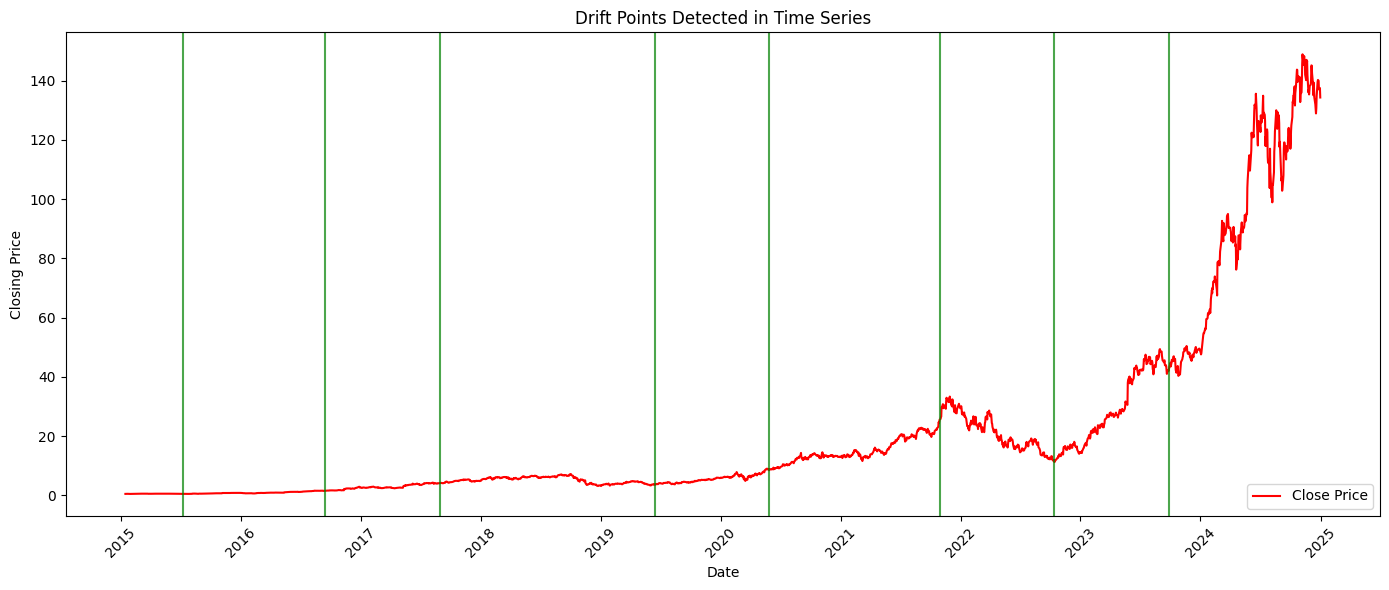

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ใช้ข้อมูล Date กับ Close price สำหรับกราฟหลัก
dates = df['Date']
prices = df['Close']

# Map drift point index เป็นวันที่
drift_dates = df.iloc[drift_points]['Date'].values

# Plot กราฟราคาพร้อมเส้นแสดง drift point
plt.figure(figsize=(14, 6))
sns.lineplot(x=dates, y=prices, label='Close Price', color='green')

# วาดเส้นแนวตั้งสำหรับแต่ละ drift point
for d in drift_dates:
    plt.axvline(x=d, color='red', linestyle='-', alpha=0.7)

# ตกแต่งกราฟ
plt.title("Drift Points Detected in NVIDIA Closing Prices")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# แปลง drift point index เป็นวันที่แบบ วัน/เดือน/ปี
drift_dates_formatted = df.iloc[drift_points]['Date'].dt.strftime('%d/%m/%Y').tolist()
print("Drift Dates of NVIDIA :")
print(drift_dates_formatted)


Drift Dates:
['09/07/2015', '15/09/2016', '29/08/2017', '14/06/2019', '28/05/2020', '29/10/2021', '13/10/2022', '28/09/2023']
